In [1]:
!pip install causalinference #install package
import pandas as pd #pandas for dataframe
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression #logistic regression model (used for propensity scores).
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score #classification performance metrics(roc_auc_score=receiver operating characterstics)
from causalinference import CausalModel
from sklearn.preprocessing import StandardScaler #standardize covariates
import warnings
warnings.filterwarnings('ignore')

ERROR: Invalid requirement: '#install': Expected package name at the start of dependency specifier
    #install
    ^


In [2]:
data = pd.read_csv(r'C:\Users\Rohini\sml_project\datasets\ihdata.csv')

In [3]:
print(data.head())

   treatment  outcome_factual  outcome_counterfactual       mu0       mu1  \
0          1         5.599916                4.318780  3.268256  6.854457   
1          0         6.875856                7.856495  6.636059  7.562718   
2          0         2.996273                6.633952  1.570536  6.121617   
3          0         1.366206                5.697239  1.244738  5.889125   
4          0         1.963538                6.202582  1.685048  6.191994   

     income  birth_weight  parent_edu  health_index  housing_quality  ...  \
0 -0.528603     -0.343455    1.128554      0.161703        -0.316603  ...   
1 -1.736945     -1.802002    0.383828      2.244320        -0.629189  ...   
2 -0.807451     -0.202946   -0.360898     -0.879606         0.808706  ...   
3  0.390083      0.596582   -1.850350     -0.879606        -0.004017  ...   
4 -1.045229     -0.602710    0.011465      0.161703         0.683672  ...   

   x20  x21  x22  x23  x24  x25  Unnamed: 26  Unnamed: 27  Unnamed: 28  \


In [4]:
# Check for missing values
print(data.isnull().sum())

treatment                 0
outcome_factual           0
outcome_counterfactual    0
mu0                       0
mu1                       0
income                    0
birth_weight              0
parent_edu                0
health_index              0
housing_quality           0
neighborhood_safety       0
x11                       0
x12                       0
x13                       0
x14                       0
x15                       0
x16                       0
x17                       0
x18                       0
x19                       0
x20                       0
x21                       0
x22                       0
x23                       0
x24                       0
x25                       0
Unnamed: 26               0
Unnamed: 27               0
Unnamed: 28               0
Unnamed: 29               0
dtype: int64


In [5]:
# Check for missing values
print(data.isnull().sum())

treatment                 0
outcome_factual           0
outcome_counterfactual    0
mu0                       0
mu1                       0
income                    0
birth_weight              0
parent_edu                0
health_index              0
housing_quality           0
neighborhood_safety       0
x11                       0
x12                       0
x13                       0
x14                       0
x15                       0
x16                       0
x17                       0
x18                       0
x19                       0
x20                       0
x21                       0
x22                       0
x23                       0
x24                       0
x25                       0
Unnamed: 26               0
Unnamed: 27               0
Unnamed: 28               0
Unnamed: 29               0
dtype: int64


In [6]:
# Summary statistics
print(data.describe())

        treatment  outcome_factual  outcome_counterfactual         mu0  \
count  747.000000       747.000000              747.000000  747.000000   
mean     0.186078         3.159538                5.696107    2.432513   
std      0.389430         2.179956                1.980121    1.281515   
min      0.000000        -1.543902               -1.037628    0.924453   
25%      0.000000         1.626779                5.053598    1.518409   
50%      0.000000         2.577294                6.209686    2.114661   
75%      0.000000         4.494637                6.948922    2.989305   
max      1.000000        11.268228               10.171004    9.821792   

              mu1        income  birth_weight    parent_edu  health_index  \
count  747.000000  7.470000e+02  7.470000e+02  7.470000e+02  7.470000e+02   
mean     6.448580 -1.204819e-11 -2.128514e-10 -2.744311e-10 -8.032091e-12   
std      0.454766  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
min      5.591647 -2.7312

In [7]:
# Check the distribution of the treatment variable
print(data['treatment'].value_counts()) #counts how many rows have treatment == 1 and treatment == 0

treatment
0    608
1    139
Name: count, dtype: int64


In [8]:
# Standardize the covariates (x1 to x25)
scaler = StandardScaler()
covariates = data.iloc[:, 5:30]  #x1 to x25 are columns 5 to 29
data.iloc[:, 5:30] = scaler.fit_transform(covariates)

In [9]:
print(data.head())

   treatment  outcome_factual  outcome_counterfactual       mu0       mu1  \
0          1         5.599916                4.318780  3.268256  6.854457   
1          0         6.875856                7.856495  6.636059  7.562718   
2          0         2.996273                6.633952  1.570536  6.121617   
3          0         1.366206                5.697239  1.244738  5.889125   
4          0         1.963538                6.202582  1.685048  6.191994   

     income  birth_weight  parent_edu  health_index  housing_quality  ...  \
0 -0.528957     -0.343685    1.129310      0.161811        -0.316815  ...   
1 -1.738109     -1.803210    0.384085      2.245823        -0.629611  ...   
2 -0.807992     -0.203082   -0.361140     -0.880195         0.809248  ...   
3  0.390344      0.596982   -1.851590     -0.880195        -0.004020  ...   
4 -1.045929     -0.603114    0.011473      0.161811         0.684130  ...   

        x20       x21       x22       x23       x24       x25  Unnamed: 26

In [10]:
print(data.describe())

        treatment  outcome_factual  outcome_counterfactual         mu0  \
count  747.000000       747.000000              747.000000  747.000000   
mean     0.186078         3.159538                5.696107    2.432513   
std      0.389430         2.179956                1.980121    1.281515   
min      0.000000        -1.543902               -1.037628    0.924453   
25%      0.000000         1.626779                5.053598    1.518409   
50%      0.000000         2.577294                6.209686    2.114661   
75%      0.000000         4.494637                6.948922    2.989305   
max      1.000000        11.268228               10.171004    9.821792   

              mu1        income  birth_weight    parent_edu  health_index  \
count  747.000000  7.470000e+02  7.470000e+02  7.470000e+02  7.470000e+02   
mean     6.448580 -3.329183e-17  2.853585e-17  2.853585e-17 -1.046315e-16   
std      0.454766  1.000670e+00  1.000670e+00  1.000670e+00  1.000670e+00   
min      5.591647 -2.7331

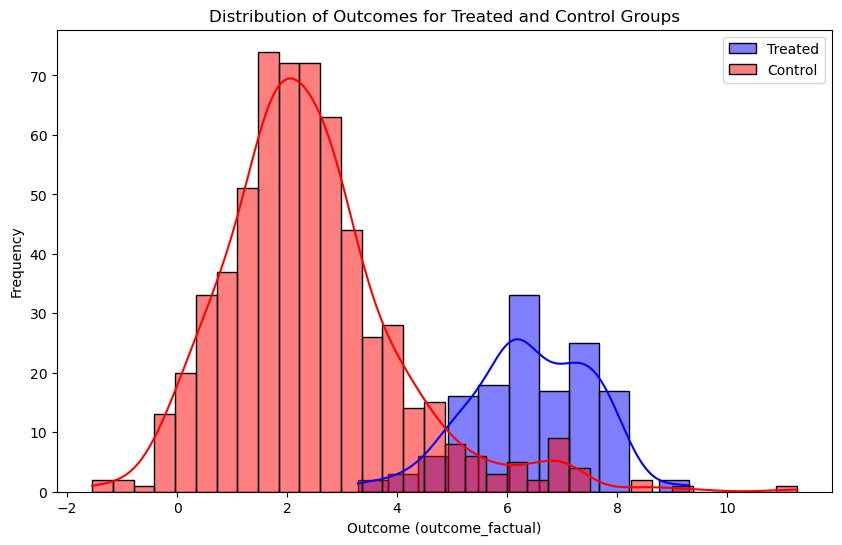

In [11]:
# Visualize the distribution of outcomes for treated and control groups
plt.figure(figsize=(10, 6))
sns.histplot(data[data['treatment'] == 1]['outcome_factual'], color='blue', label='Treated', kde=True)#treated
sns.histplot(data[data['treatment'] == 0]['outcome_factual'], color='red', label='Control', kde=True)#controlled
plt.title('Distribution of Outcomes for Treated and Control Groups')
plt.xlabel('Outcome (outcome_factual)')
plt.ylabel('Frequency')
plt.legend()
plt.show()


In [12]:
# 1. Treatment has a positive effect on the outcome.
# 2. Certain covariates (e.g., x1, x2) may confound the relationship between treatment and outcome.

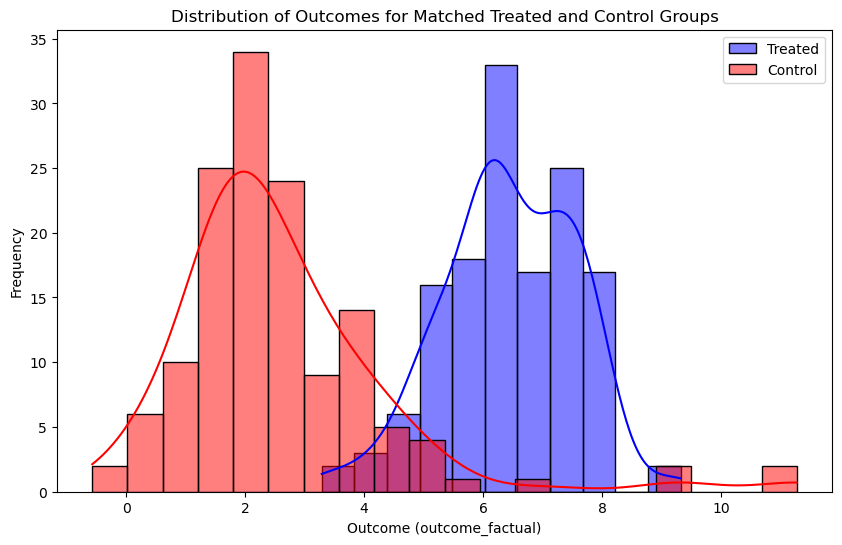

In [13]:
# Estimate propensity scores using logistic regression
X = data.iloc[:, 5:30]  # Covariates
y = data['treatment']  # Treatment

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fit logistic regression model
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

# Predict propensity scores
data['propensity_score'] = log_reg.predict_proba(X)[:, 1] #predict probability of treatment for every row

# Perform propensity score matching
from sklearn.neighbors import NearestNeighbors

# Create a matching function
def propensity_score_matching(data, treatment_col='treatment', propensity_col='propensity_score'):
    treated = data[data[treatment_col] == 1]
    control = data[data[treatment_col] == 0]

    nbrs = NearestNeighbors(n_neighbors=1).fit(control[[propensity_col]]) #fit nearest neighbor indexer on control propensity scores.
    distances, indices = nbrs.kneighbors(treated[[propensity_col]])#find closest control for each treated row.

    matched_control = control.iloc[indices.flatten()]
    matched_data = pd.concat([treated, matched_control])#combine treated and closest matched controls.

    return matched_data

matched_data = propensity_score_matching(data)

# Compare outcomes between matched treated and control groups
plt.figure(figsize=(10, 6))
sns.histplot(matched_data[matched_data['treatment'] == 1]['outcome_factual'], color='blue', label='Treated', kde=True)
sns.histplot(matched_data[matched_data['treatment'] == 0]['outcome_factual'], color='red', label='Control', kde=True)
plt.title('Distribution of Outcomes for Matched Treated and Control Groups')
plt.xlabel('Outcome (outcome_factual)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [14]:
# Calculate inverse probability weights
data['ipw'] = np.where(data['treatment'] == 1, 1/data['propensity_score'], 1/(1-data['propensity_score']))

# Estimate ATE using IPW
ate_ipw = np.mean(data['treatment'] * data['outcome_factual'] / data['propensity_score']) - np.mean((1 - data['treatment']) * data['outcome_factual'] / (1 - data['propensity_score']))
print(f'Estimated ATE using IPW: {ate_ipw}')

Estimated ATE using IPW: 3.6592503523295


In [15]:
# Estimate propensity scores using logistic regression
X = data.iloc[:, 5:30]  # Covariates
y = data['treatment']  # Treatment

# Fit logistic regression model
log_reg = LogisticRegression()
log_reg.fit(X, y)

# Predict propensity scores
data['propensity_score'] = log_reg.predict_proba(X)[:, 1]

In [16]:
# Create CausalModel
causal = CausalModel(
    Y=data['outcome_factual'].values,  # Outcome
    D=data['treatment'].values,  # Treatment
    X=data.iloc[:, 5:30].values  # Covariates
)

# Add propensity scores to the CausalModel
causal.pscore = data['propensity_score'].values

In [17]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from causalinference import CausalModel

# Load dataset
data = pd.read_csv(r'C:\Users\Rohini\sml_project\datasets\ihdata.csv')

# Select covariates and treatment
X = data.iloc[:, 5:30]  # Covariates
y = data["treatment"]  # Treatment

# Fit logistic regression model for propensity score estimation
log_reg = LogisticRegression(solver="liblinear")
log_reg.fit(X, y)

# Predict propensity scores
data["propensity_score"] = log_reg.predict_proba(X)[:, 1]

# Create CausalModel
causal = CausalModel(
    Y=data["outcome_factual"].values,  # Outcome
    D=data["treatment"].values,  # Treatment
    X=data.iloc[:, 5:30].values,  # Covariates
)

# Estimate propensity scores using built-in method
causal.est_propensity_s()

# Estimate ATE using OLS
causal.est_via_ols()

# Estimate ATE using Matching
causal.est_via_matching(bias_adj=True)

# Estimate ATE using Weighting (IPW)
causal.est_via_weighting()

# Print the estimated results
print(causal.estimates)


Treatment Effect Estimates: OLS

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      3.961      0.106     37.461      0.000      3.754      4.168
           ATC      3.974      0.114     34.792      0.000      3.750      4.198
           ATT      3.905      0.104     37.681      0.000      3.702      4.108

Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      3.956      0.190     20.765      0.000      3.582      4.329
           ATC      3.942      0.204     19.310      0.000      3.542      4.342
           ATT      4.017      0.215     18.726      0.000      3.596      4.437

Treatment Effect Estimates: Weighting

                     Est.       S.e.          z      P>|z|      [95% Conf. in

In [18]:
# Example: Calculate CATE for different subgroups based on a covariate (e.g., x1)

# List of columns to loop over
cols = ['income', 'birth_weight', 'parent_edu', 'health_index', 
        'housing_quality', 'neighborhood_safety'] + [f'x{i}' for i in range(11, 26)]

# Dictionary to store results
cate_results = {}

for col in cols:
    # Create Low/High groups
    data[f'{col}_group'] = pd.cut(data[col], bins=[-np.inf, 0, np.inf], labels=['Low', 'High'])
    
    # Calculate CATE for Low and High
    cate_low = data[data[f'{col}_group'] == 'Low']['treatment'].mean() - \
               data[data[f'{col}_group'] == 'Low']['outcome_factual'].mean()
    cate_high = data[data[f'{col}_group'] == 'High']['treatment'].mean() - \
                data[data[f'{col}_group'] == 'High']['outcome_factual'].mean()
    
    # Save results
    cate_results[col] = {'Low': cate_low, 'High': cate_high}

# Convert results to a DataFrame for easier view
cate_df = pd.DataFrame(cate_results).T
print(cate_df)


                          Low      High
income              -2.894155 -3.038645
birth_weight        -2.830939 -3.080267
parent_edu          -2.936443 -3.015902
health_index        -2.759458 -3.158110
housing_quality     -3.002608 -2.948037
neighborhood_safety -2.229777 -3.863693
x11                 -3.081207 -2.871606
x12                 -2.952389 -3.177249
x13                 -2.533250 -3.378589
x14                 -3.221035 -2.541113
x15                 -3.064546 -2.726031
x16                 -2.910138 -3.198563
x17                 -2.947495 -3.019867
x18                       NaN -2.973460
x19                 -2.795028 -4.064443
x20                 -3.851976 -2.936702
x21                 -2.615464 -3.217768
x22                 -2.445296 -2.993266
x23                 -2.984204 -2.904738
x24                 -2.969591 -2.998208
x25                 -2.922809 -3.246196


In [19]:
import pickle
# Create a dictionary to store all results
results = {
    'causal_model': causal,  # Save the CausalModel object
    'propensity_scores': data['propensity_score'],  # Save propensity scores
    'ate_estimates': causal.estimates,  # Save ATE estimates
    'cate_results': cate_results  # Save CATE results (if calculated)
}

# Save the results dictionary to a .pkl file
with open('causal_analysis_results.pkl', 'wb') as f:
    pickle.dump(results, f)

print("Results saved to causal_analysis_results.pkl")

Results saved to causal_analysis_results.pkl


In [20]:
import pandas as pd
import pickle

# Load pickle
with open("causal_analysis_results.pkl", "rb") as f:
    data = pickle.load(f)

# Convert dict to DataFrame
df = pd.DataFrame(list(data.items()), columns=['Key', 'Value'])

# Save as CSV with UTF-8
df.to_csv("causal_analysis_results_utf8.csv", index=False, encoding="utf-8")


In [21]:
df

,Key,Value
0,causal_model,<causalinference.causal.CausalModel object at ...
1,propensity_scores,0 0.305590 1 0.058194 2 0.10886...
2,ate_estimates,\nTreatment Effect Estimates: OLS\n\n ...
3,cate_results,"{'income': {'Low': -2.894155065178041, 'High':..."
